# Volume Prediction from Images Using Deep Learning

This notebook trains a ResNet-50 model to predict liquid volume in test tubes from grayscale images. The model uses transfer learning and data augmentation to achieve accurate predictions.

## 1. Import Libraries

Import all required libraries for data processing, visualization, deep learning, and model evaluation.

In [31]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


## 2. Set Random Seeds for Reproducibility

Ensure consistent results across multiple runs by setting seeds for all random number generators.

In [32]:
# Reproducibility
SEED = 3
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);


## 3. Load Data from Excel

Read experimental data containing:
- **Number of droplets** per tube
- **Initial tube weights** (before adding liquid)
- **Final tube weights** (after adding liquid)

Volume is calculated as: `Volume = Final Weight - Initial Weight`

In [33]:
data_dir = r"D:\Code\liquid-measure\VolPicturesRound1"

xls_path = os.path.join(data_dir, "HFB Volume Image Gathering.xlsx")

drops_df = pd.read_excel(xls_path, sheet_name="# of Droplets", header=None)
pre_df   = pd.read_excel(xls_path, sheet_name="Initial Tube Weights", header=None)
post_df  = pd.read_excel(xls_path, sheet_name="Final Tube Weights", header=None)


## 4. Load and Preprocess Images

Process all tube images from 10 runs × 20 tubes = 200 images:
- Convert to **grayscale** (single channel)
- Resize to **320×160 pixels**
- Normalize pixel values to **[0, 1]** range
- Extract volume labels from weight differences

In [34]:
wIm, hIm = 320, 160
nRuns, nTubes = 10, 20

images = []
volumes = []
drops = []
labels = []

for run in range(1, nRuns + 1):
    for tube in range(1, nTubes + 1):
        try:
            img_path = os.path.join(
                data_dir,
                f"Attempt{run}",
                f"Run{run}Rig1Tube{tube}final.bmp"
            )
            
            img = Image.open(img_path).convert("L")
            img = img.resize((wIm, hIm))
            img = np.array(img, dtype=np.float32) / 255.0
            
            vol = post_df.iloc[run, tube] - pre_df.iloc[run, tube]
            nd  = drops_df.iloc[run, tube]

            images.append(img)
            volumes.append(vol)
            drops.append(nd)
            labels.append([run, tube])

        except Exception as e:
            print(f"Run {run} Tube {tube} failed:", e)


print(f"\n✓ Loaded {len(images)} images successfully");
print(f"  Image shape: {wIm}x{hIm}");
print(f"  Volume range: [{min(volumes):.3f}, {max(volumes):.3f}]")

Run 4 Tube 1 failed: [Errno 2] No such file or directory: 'D:\\Code\\liquid-measure\\VolPicturesRound1\\Attempt4\\Run4Rig1Tube1final.bmp'
Run 4 Tube 8 failed: [Errno 2] No such file or directory: 'D:\\Code\\liquid-measure\\VolPicturesRound1\\Attempt4\\Run4Rig1Tube8final.bmp'
Run 4 Tube 15 failed: [Errno 2] No such file or directory: 'D:\\Code\\liquid-measure\\VolPicturesRound1\\Attempt4\\Run4Rig1Tube15final.bmp'
Run 5 Tube 12 failed: [Errno 2] No such file or directory: 'D:\\Code\\liquid-measure\\VolPicturesRound1\\Attempt5\\Run5Rig1Tube12final.bmp'
Run 5 Tube 13 failed: [Errno 2] No such file or directory: 'D:\\Code\\liquid-measure\\VolPicturesRound1\\Attempt5\\Run5Rig1Tube13final.bmp'
Run 5 Tube 14 failed: [Errno 2] No such file or directory: 'D:\\Code\\liquid-measure\\VolPicturesRound1\\Attempt5\\Run5Rig1Tube14final.bmp'

✓ Loaded 194 images successfully
  Image shape: 320x160
  Volume range: [-0.002, 0.986]


## 5. Convert to NumPy Arrays

Prepare data for model input by converting lists to efficient NumPy arrays.

In [35]:
X = np.stack(images)
y = np.array(volumes, dtype=np.float32)


### Visualize Sample Images

Let's look at some actual tube images to understand the data.

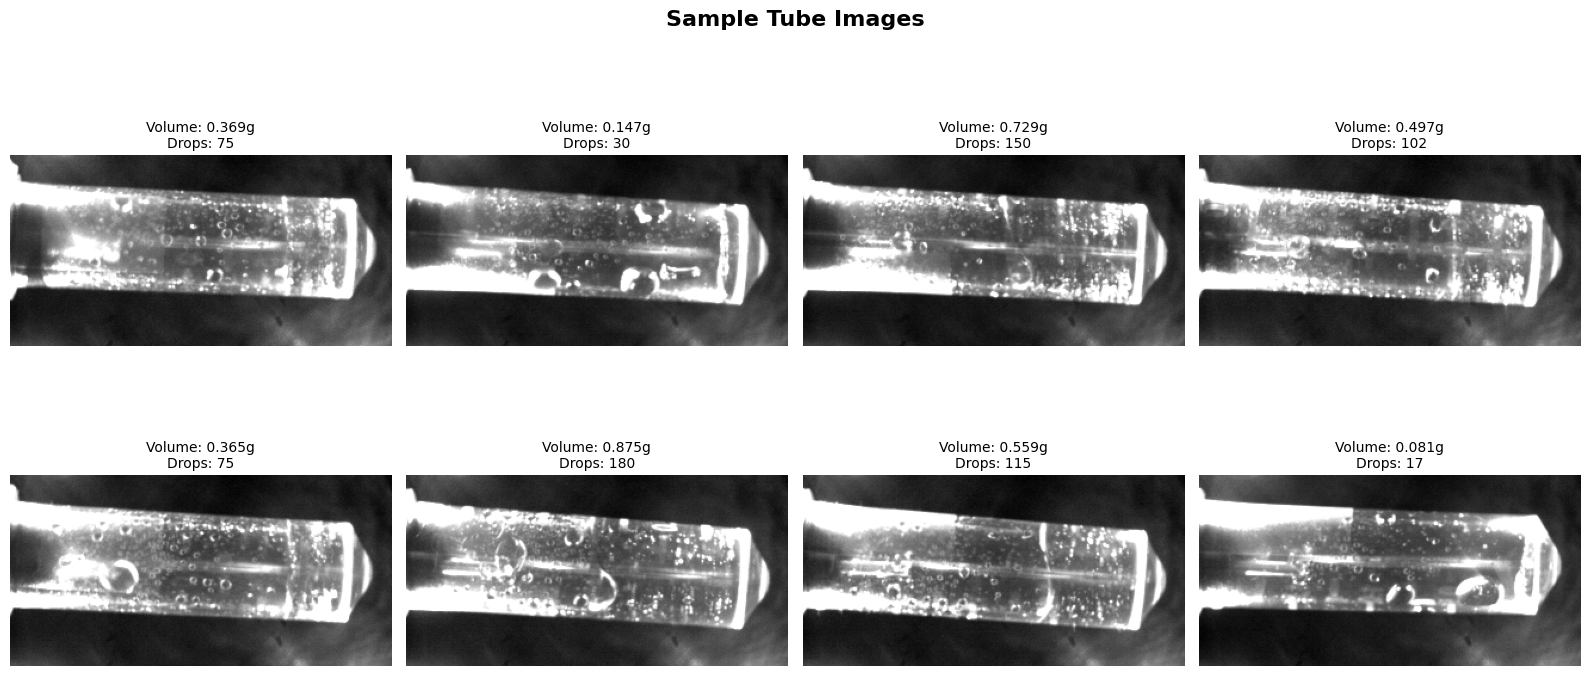

In [36]:
# Display 8 random sample images with their volumes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
sample_indices = np.random.choice(len(images), 8, replace=False)

for idx, ax in zip(sample_indices, axes.flat):
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f'Volume: {volumes[idx]:.3f}g\nDrops: {drops[idx]}', fontsize=10)
    ax.axis('off')

plt.suptitle('Sample Tube Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Exploratory Data Analysis

Visualize the relationship between number of droplets and measured volume to verify data quality.

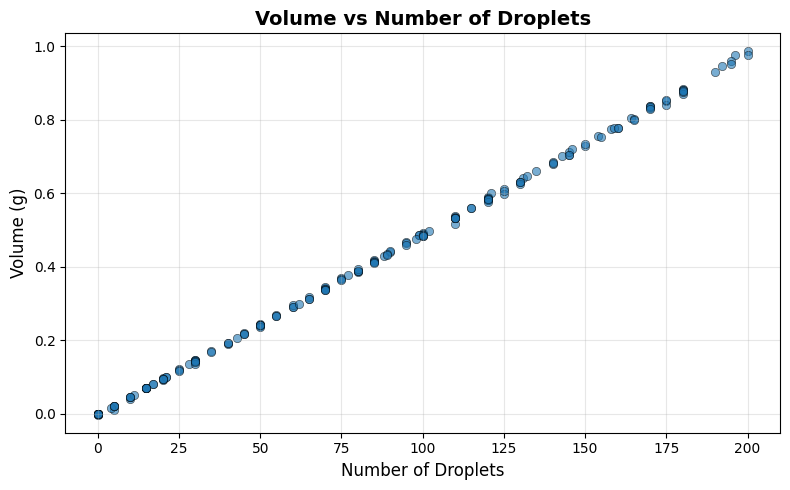

In [37]:
plt.figure(figsize=(8, 5))
plt.scatter(drops, y, alpha=0.6, edgecolors='k', linewidths=0.5)
plt.xlabel("Number of Droplets", fontsize=12)
plt.ylabel("Volume (g)", fontsize=12)
plt.title("Volume vs Number of Droplets", fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Split Data into Training and Test Sets

Split data using **80/20 ratio**:
- **Training set**: Used to train the model
- **Test set**: Used to evaluate final performance (held out during training)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

Training set: 155 samples
Test set: 39 samples (20.1%)


## 7. Define Data Augmentation Transforms

**Training transforms** (increase model robustness):
- Random rotation: ±15 degrees
- Random translation: ±10 pixels
- Convert to tensor

**Test transforms** (no augmentation for consistent evaluation):
- Only convert to tensor

In [39]:
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(
        degrees=15,
        translate=(10/320, 10/160)
    ),
    transforms.ToTensor()
])

test_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])


### Visualize Augmentation Effects

See how data augmentation transforms images during training.

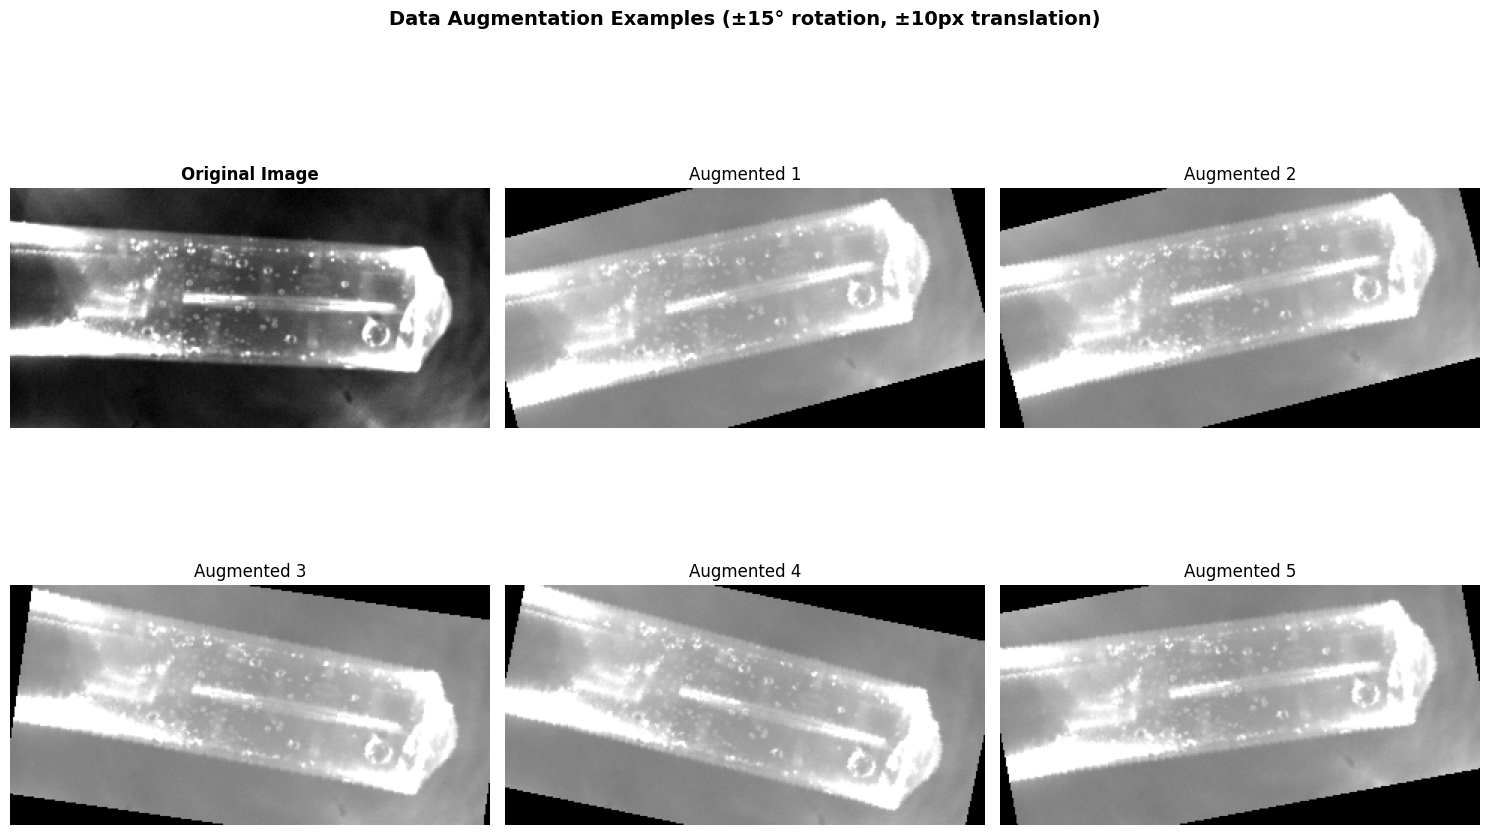

In [40]:
# Show original image and 5 augmented versions
sample_img = images[0]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original
axes[0, 0].imshow(sample_img, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Augmented versions
for i, ax in enumerate(axes.flat[1:], 1):
    aug_img = train_tf((sample_img * 255).astype(np.uint8))
    ax.imshow(aug_img.squeeze(), cmap='gray')
    ax.set_title(f'Augmented {i}', fontsize=12)
    ax.axis('off')

plt.suptitle('Data Augmentation Examples (±15° rotation, ±10px translation)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Create Custom PyTorch Dataset

Custom `Dataset` class that:
- Stores images and labels
- Applies transformations on-the-fly during training
- Returns (image, volume) pairs for the DataLoader

In [41]:
class VolumeDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        img = (img * 255).astype(np.uint8)

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img).unsqueeze(0)

        return img, torch.tensor(self.y[idx])


## 9. Create DataLoaders

Configure data loading for efficient batch processing:
- **Batch size**: 10 samples per batch
- **Training**: Shuffled for better generalization
- **Test**: Sequential for consistent evaluation

In [42]:
train_ds = VolumeDataset(X_train, y_train, train_tf)
test_ds  = VolumeDataset(X_test, y_test, test_tf)

train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=10, shuffle=False)


## 10. Build the Neural Network

**Model Architecture:**
- **Base**: ResNet-50 pretrained on ImageNet (transfer learning)
- **Input layer**: Modified first conv layer for grayscale images (1 channel instead of 3)
- **Regression head**: Custom fully-connected layers
  - 2048 → 100 (with ReLU)
  - 100 → 10 (with ReLU)
  - 10 → 1 (output: predicted volume)

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights=True)

model.conv1 = nn.Conv2d(
    1, 64, kernel_size=7, stride=2, padding=3, bias=False
)

model.fc = nn.Sequential(
    nn.Linear(2048, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

model.to(device)


print(f"✓ Model loaded on device: {device}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model loaded on device: cpu
  Total parameters: 23,707,681
  Trainable parameters: 23,707,681


## 11. Configure Training Components

**Loss Function**: Mean Squared Error (MSE) - standard for regression tasks  
**Optimizer**: Adam with learning rate = 0.001 (adaptive learning rates)  
**Scheduler**: StepLR - reduces learning rate by 50% every 200 epochs for fine-tuning

In [44]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=200, gamma=0.5
)


## 12. Train the Model

Train for **23 epochs** with real-time monitoring:
- Progress bar shows batch-level progress
- Display current batch loss
- Print epoch summary with average loss and learning rate

In [45]:
epochs = 23
print("Training started...")

# Track training history
history = {'epoch': [], 'loss': [], 'lr': []}

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for x, yb in pbar:
        x, yb = x.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(x).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    scheduler.step()
    
    avg_loss = epoch_loss/len(train_loader)
    
    # Store history
    history['epoch'].append(epoch + 1)
    history['loss'].append(avg_loss)
    history['lr'].append(scheduler.get_last_lr()[0])
    
    print(f"Epoch {epoch+1:3d}/{epochs} | Avg Loss: {avg_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}\n")


print("✓ Training complete!")

Training started...


Epoch 1/23: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it, loss=0.0746]


Epoch   1/23 | Avg Loss: 0.0689 | LR: 0.001000



Epoch 2/23: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it, loss=0.0266]


Epoch   2/23 | Avg Loss: 0.0431 | LR: 0.001000



Epoch 3/23: 100%|██████████| 16/16 [00:38<00:00,  2.43s/it, loss=0.0042]


Epoch   3/23 | Avg Loss: 0.0210 | LR: 0.001000



Epoch 4/23: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it, loss=0.0205]


Epoch   4/23 | Avg Loss: 0.0215 | LR: 0.001000



Epoch 5/23: 100%|██████████| 16/16 [00:38<00:00,  2.43s/it, loss=0.0173]


Epoch   5/23 | Avg Loss: 0.0228 | LR: 0.001000



Epoch 6/23: 100%|██████████| 16/16 [00:37<00:00,  2.33s/it, loss=0.0093]


Epoch   6/23 | Avg Loss: 0.0099 | LR: 0.001000



Epoch 7/23: 100%|██████████| 16/16 [00:37<00:00,  2.33s/it, loss=0.0054]


Epoch   7/23 | Avg Loss: 0.0107 | LR: 0.001000



Epoch 8/23: 100%|██████████| 16/16 [00:39<00:00,  2.48s/it, loss=0.0284]


Epoch   8/23 | Avg Loss: 0.0136 | LR: 0.001000



Epoch 9/23: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it, loss=0.0238]


Epoch   9/23 | Avg Loss: 0.0143 | LR: 0.001000



Epoch 10/23: 100%|██████████| 16/16 [00:36<00:00,  2.27s/it, loss=0.0294]


Epoch  10/23 | Avg Loss: 0.0114 | LR: 0.001000



Epoch 11/23: 100%|██████████| 16/16 [00:36<00:00,  2.26s/it, loss=0.0069]


Epoch  11/23 | Avg Loss: 0.0116 | LR: 0.001000



Epoch 12/23: 100%|██████████| 16/16 [00:38<00:00,  2.39s/it, loss=0.0313]


Epoch  12/23 | Avg Loss: 0.0214 | LR: 0.001000



Epoch 13/23: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it, loss=0.0298]


Epoch  13/23 | Avg Loss: 0.0195 | LR: 0.001000



Epoch 14/23: 100%|██████████| 16/16 [00:38<00:00,  2.42s/it, loss=0.0026]


Epoch  14/23 | Avg Loss: 0.0209 | LR: 0.001000



Epoch 15/23: 100%|██████████| 16/16 [00:37<00:00,  2.33s/it, loss=0.0142]


Epoch  15/23 | Avg Loss: 0.0140 | LR: 0.001000



Epoch 16/23: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=0.0046]


Epoch  16/23 | Avg Loss: 0.0140 | LR: 0.001000



Epoch 17/23: 100%|██████████| 16/16 [00:37<00:00,  2.33s/it, loss=0.0147]


Epoch  17/23 | Avg Loss: 0.0130 | LR: 0.001000



Epoch 18/23: 100%|██████████| 16/16 [00:37<00:00,  2.34s/it, loss=0.0091]


Epoch  18/23 | Avg Loss: 0.0152 | LR: 0.001000



Epoch 19/23: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it, loss=0.0172]


Epoch  19/23 | Avg Loss: 0.0103 | LR: 0.001000



Epoch 20/23: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it, loss=0.0302]


Epoch  20/23 | Avg Loss: 0.0117 | LR: 0.001000



Epoch 21/23: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it, loss=0.0117]


Epoch  21/23 | Avg Loss: 0.0118 | LR: 0.001000



Epoch 22/23: 100%|██████████| 16/16 [00:37<00:00,  2.31s/it, loss=0.0112]


Epoch  22/23 | Avg Loss: 0.0095 | LR: 0.001000



Epoch 23/23: 100%|██████████| 16/16 [00:36<00:00,  2.30s/it, loss=0.0044]

Epoch  23/23 | Avg Loss: 0.0101 | LR: 0.001000

✓ Training complete!


### Save Trained Model

Save the model to disk for later use without retraining. Two methods are provided:
- **State dict** (recommended): Saves only model weights - smaller file size
- **Full model**: Saves entire model architecture and weights

In [53]:
# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Method 1: Save state dictionary (RECOMMENDED - smaller file)
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'training_history': history,
    'rmse': rmse if 'rmse' in locals() else None
}, 'models/volume_predictor_resnet50.pth')

print("✓ Model saved successfully!")
print(f"  Location: models/volume_predictor_resnet50.pth")
print(f"  File size: {os.path.getsize('models/volume_predictor_resnet50.pth') / (1024*1024):.2f} MB")

# Optional: Save full model (larger file, but easier to load)
# torch.save(model, 'models/volume_predictor_full.pth')

✓ Model saved successfully!
  Location: models/volume_predictor_resnet50.pth
  File size: 271.76 MB


### Load Saved Model (For Future Use)

Example code showing how to load the saved model later:

In [47]:
# Example: How to load the model later (don't run now if continuing with current model)

"""
# To load the model in a new session:

# 1. Recreate the model architecture
loaded_model = models.resnet50(weights=False)
loaded_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
loaded_model.fc = nn.Sequential(
    nn.Linear(2048, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# 2. Load the saved checkpoint
checkpoint = torch.load('models/volume_predictor_resnet50.pth', map_location=device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.to(device)
loaded_model.eval()

# 3. Access training history if needed
training_history = checkpoint['training_history']
final_rmse = checkpoint['rmse']

print(f"✓ Model loaded successfully!")
print(f"  Trained for {checkpoint['epoch']} epochs")
print(f"  Test RMSE: {final_rmse:.4f}")
"""

print("ℹ️  Load instructions saved (commented out)")
print("   Uncomment and run this cell to load the model in future sessions")

ℹ️  Load instructions saved (commented out)
   Uncomment and run this cell to load the model in future sessions


### Training History

Visualize how the model learned over time.

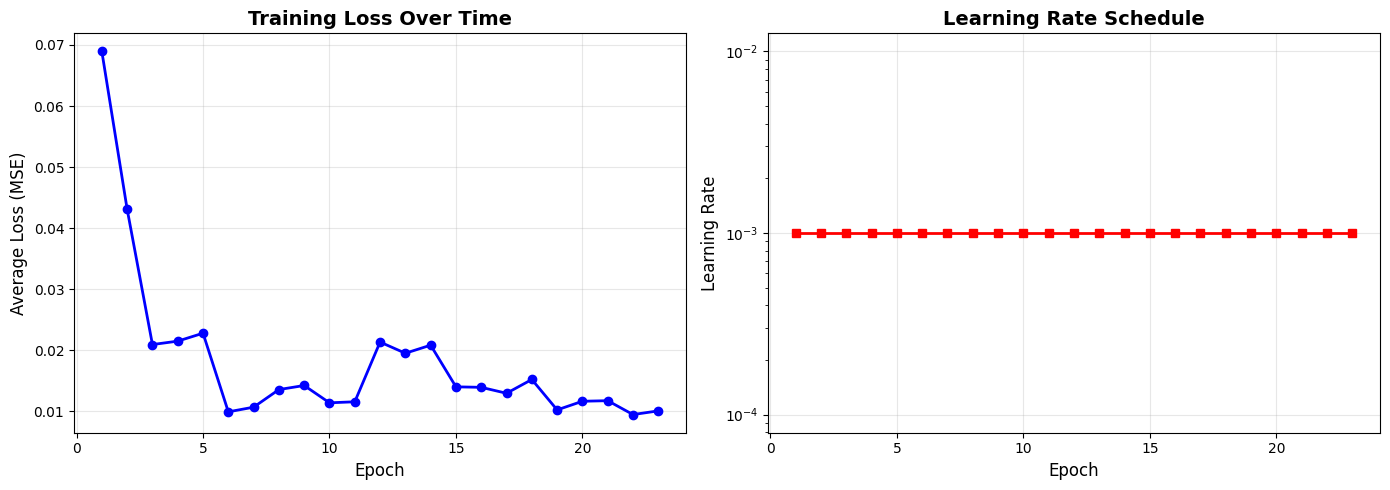

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['epoch'], history['loss'], 'b-', linewidth=2, marker='o')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Average Loss (MSE)', fontsize=12)
axes[0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1].plot(history['epoch'], history['lr'], 'r-', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

## 13. Evaluate Model Performance

**Evaluation Metrics:**
- Set model to evaluation mode (disables dropout/batch norm training behavior)
- Generate predictions on test set
- Calculate **RMSE** (Root Mean Squared Error): measures average prediction error

In [55]:
model.eval()

def predict(loader):
    preds = []
    targets = []
    with torch.no_grad():
        for x, yb in loader:
            x = x.to(device)
            p = model(x).cpu().numpy().squeeze()
            preds.extend(p)
            targets.extend(yb.numpy())
    return np.array(preds), np.array(targets)

y_pred_test, y_true_test = predict(test_loader)
rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print(f"\n{'='*40}")

print(f"Test Set Performance")

print(f"{'='*40}")
print(f"{'='*40}")
print(f"RMSE: {rmse:.4f}")
print(f"Number of test samples: {len(y_true_test)}")


Test Set Performance
RMSE: 0.4432
Number of test samples: 39


### Sample Predictions with Images

Visual inspection of best and worst predictions.

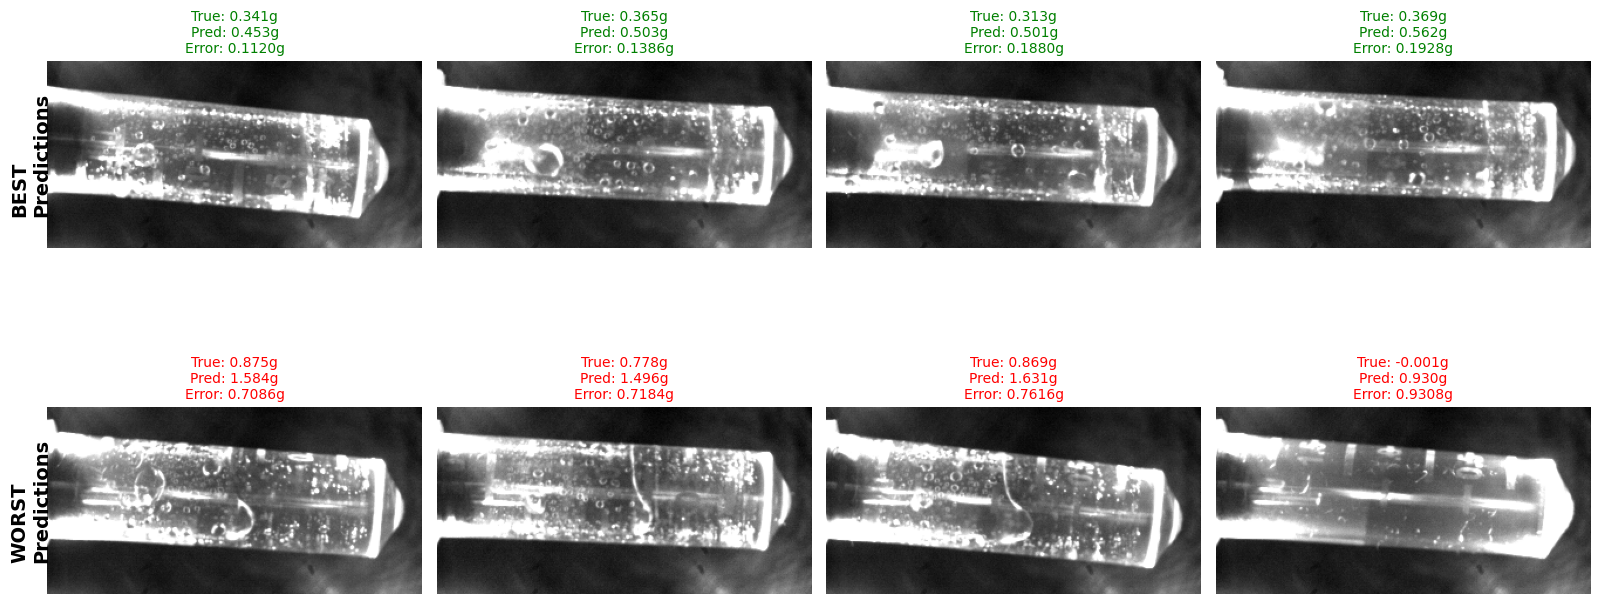

In [57]:
# Calculate residuals
residuals = y_true_test - y_pred_test
errors = np.abs(residuals)

# Find best and worst predictions
best_idx = np.argsort(errors)[:4]
worst_idx = np.argsort(errors)[-4:]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Best predictions
for i, (idx, ax) in enumerate(zip(best_idx, axes[0])):
    ax.imshow(X_test[idx], cmap='gray')
    ax.set_title(f'True: {y_true_test[idx]:.3f}g\nPred: {y_pred_test[idx]:.3f}g\nError: {errors[idx]:.4f}g', 
                 fontsize=10, color='green')
    ax.axis('off')

# Worst predictions
for i, (idx, ax) in enumerate(zip(worst_idx, axes[1])):
    ax.imshow(X_test[idx], cmap='gray')
    ax.set_title(f'True: {y_true_test[idx]:.3f}g\nPred: {y_pred_test[idx]:.3f}g\nError: {errors[idx]:.4f}g', 
                 fontsize=10, color='red')
    ax.axis('off')

axes[0, 0].text(-0.1, 0.5, 'BEST\nPredictions', transform=axes[0, 0].transAxes,
                fontsize=14, fontweight='bold', va='center', rotation=90)
axes[1, 0].text(-0.1, 0.5, 'WORST\nPredictions', transform=axes[1, 0].transAxes,
                fontsize=14, fontweight='bold', va='center', rotation=90)

plt.tight_layout()
plt.show()

### Visualize Predictions vs Ground Truth

Scatter plot comparing predicted volumes against true volumes:
- Points on the **red dashed line** indicate perfect predictions
- Deviation from the line shows prediction errors

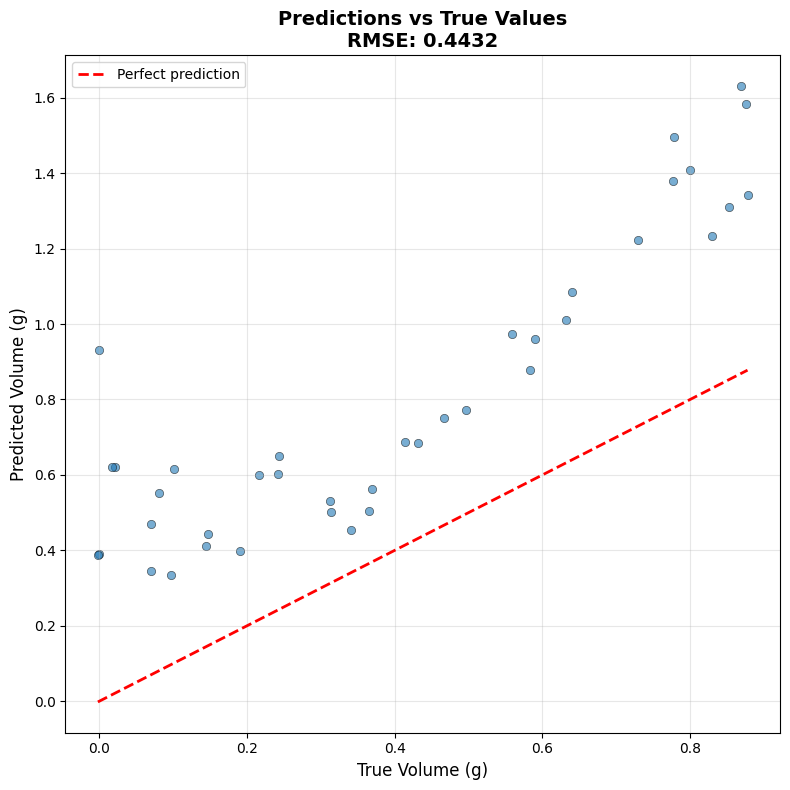

In [58]:
plt.figure(figsize=(8, 8))
plt.scatter(y_true_test, y_pred_test, alpha=0.6, edgecolors='k', linewidths=0.5)
plt.plot([y_true_test.min(), y_true_test.max()], 
         [y_true_test.min(), y_true_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel("True Volume (g)", fontsize=12)
plt.ylabel("Predicted Volume (g)", fontsize=12)
plt.title(f"Predictions vs True Values\nRMSE: {rmse:.4f}", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Test-Time Augmentation (TTA)

**Advanced technique to improve predictions:**
1. Create **20 augmented versions** of each test image (with random rotations/translations)
2. Get predictions for all augmented versions
3. **Average** the predictions to reduce variance
4. Compare RMSE improvement over standard single-prediction approach


In [52]:
def augmented_predict(img, n_aug=20):
    preds = []
    for _ in range(n_aug):
        aug_img = train_tf((img * 255).astype(np.uint8)).unsqueeze(0).to(device)
        preds.append(model(aug_img).item())
    return np.mean(preds)

print("Running augmented predictions...")
aug_preds = np.array([
    augmented_predict(img) for img in tqdm(X_test, desc="Predicting")
])

aug_rmse = np.sqrt(mean_squared_error(y_test, aug_preds))

print(f"\n{'='*40}")

print(f"Augmented Test Set Performance")
print(f"{'='*40}")
print(f"{'='*40}")
print(f"Improvement:    {(rmse - aug_rmse)/rmse * 100:.2f}%")
print(f"Augmented RMSE: {aug_rmse:.4f}")
print(f"Standard RMSE:  {rmse:.4f}")

Running augmented predictions...


Predicting: 100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Augmented Test Set Performance
Improvement:    4.20%
Augmented RMSE: 0.4246
Standard RMSE:  0.4432
